# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
! pip install catboost

In [2]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer, f1_score
import lightgbm as lgb
from sklearn.utils import shuffle
from timeit import timeit
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
from catboost.utils import eval_metric
pd.options.display.max_columns = None

In [3]:
def split_dataset(df, t, drop = [], cat_cols = [], num_cols=[]):
    ds = df.drop(index=df.index[df[t].isna()])

    for cat in cat_cols:
        cat_target_encode = ds.pivot_table(index=cat, values=t, aggfunc='mean').to_dict()[t]
        ds[cat] = ds[cat].apply(lambda x: cat_target_encode[x])
        
    target = ds[t]
    features = ds.drop(columns=drop + [t])
    
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, random_state=12345, test_size=0.2)

    features = [features_train, features_test]
    targets = [target_train, target_test]
    
    transformer = make_column_transformer(
        (MinMaxScaler(), num_cols),
        remainder='passthrough')
    
    transformed = transformer.fit_transform(features[0])
    features[0] = pd.DataFrame(data=transformed, columns=features[0].columns)
        
    
    return [features, targets]

## Подготовка данных

### Обзор данных

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [5]:
df = pd.read_csv('/datasets/autos.csv')
source_df_len = len(df)
num_df = df.select_dtypes(include=numerics)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

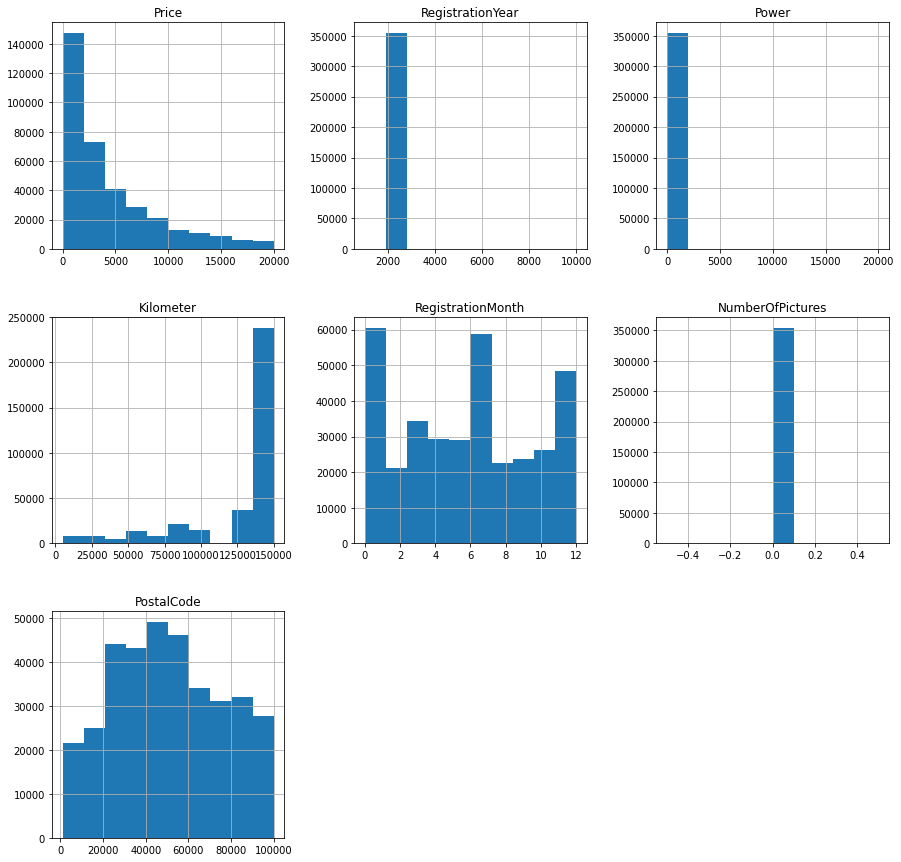

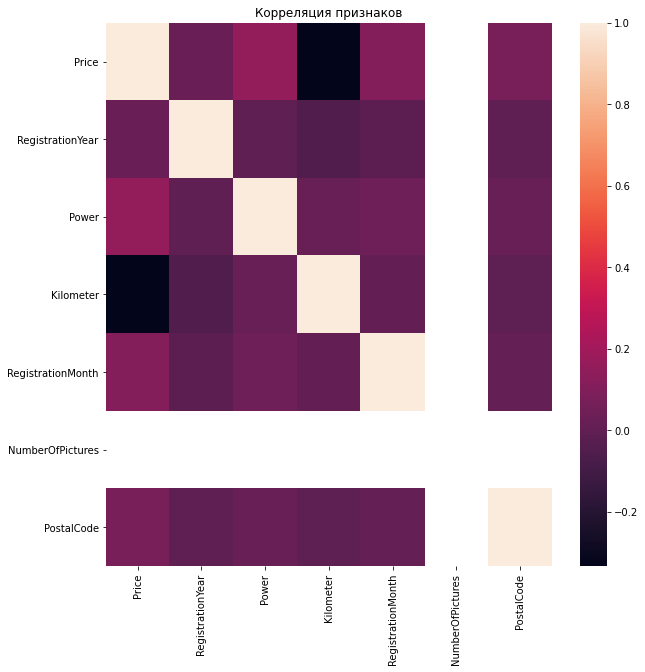

In [7]:
num_df.hist(figsize=(15,15))
plt.subplots(figsize=(10, 10), )
ax = plt.axes()
sns.heatmap(num_df.corr(), ax=ax)
ax.set_title('Корреляция признаков');

Цена имеет среднюю линейную зависимость от пробега.

Колонки **DateCrawled**, **DateCreated**, **PostalCode**, **LastSeen**, **RegistrationMonth** откидываются, т.к. они неинформативны. Колонка **NumberOfPictures** откидывается т.к. она содержит константное значение.

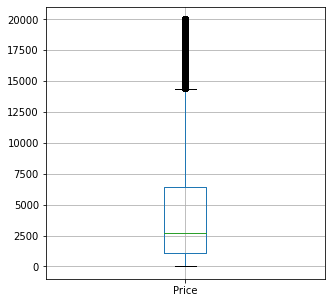

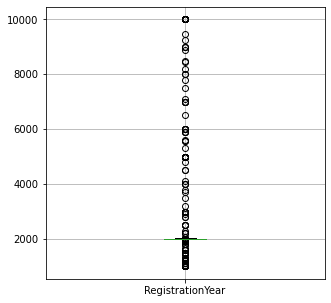

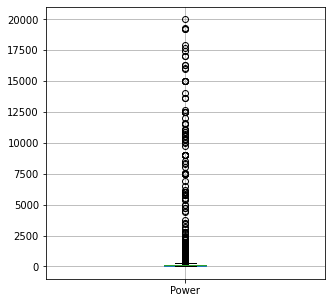

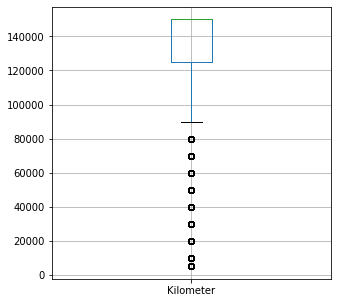

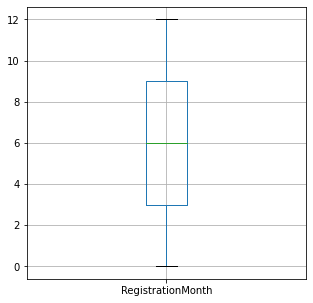

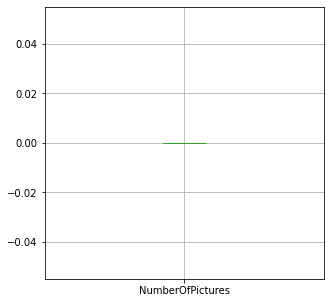

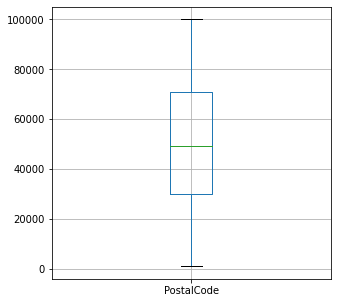

In [8]:
for col in num_df.columns:
    plt.subplots(figsize=(5, 5))
    num_df.boxplot(column=col)

In [9]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [10]:
df['Kilometer'].corr(df['Price'])

-0.333199489486105

In [11]:
df.drop(columns=['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures', "RegistrationMonth"], inplace=True)

### Преобразования данных

Значения колонок **Repaired** и **Gearbox** переводятся в булев тип.

In [12]:
df['Repaired'] = df['Repaired'].apply(lambda x: np.nan if pd.isna(x) else 1 if x == "yes" else 0)
df['Gearbox'] = df['Gearbox'].apply(lambda x: np.nan if pd.isna(x) else 1 if x == "auto" else 0)

### Работа с дубликатами

Содержание дубликатов по оставшимся колонкам:

In [13]:
dups = df.duplicated().sum()
source_df_len -= dups
dups

45040

Дубликаты отбрасываются

In [14]:
df.drop_duplicates(inplace=True)

### Обработка аномальных значений

Откидываются объекты, имеющие значения в колонке **Power**, не попадющие в интервал от 13 до 1000 л.с.

Откидываются объекты, имеющие значения в колонке **RegistrationYear**, не попадющие в интервал с 1950 по 2016 год.

Откидываются объекты, имеющие значения в колонке **Price** менее 15 евро.

In [15]:
df.drop(index=df[(df['Power'] <= 13) | (df['Power'] >= 1000)].index, inplace = True)
df.drop(index=df[df['Price'] <= 15].index, inplace = True)
df.drop(index=df[(df['RegistrationYear'] <= 1950) | (df['RegistrationYear'] > 2016)].index, inplace = True)

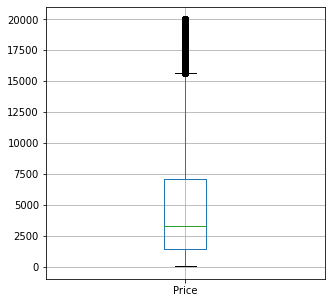

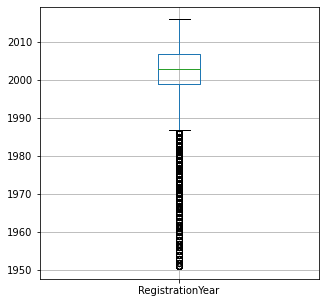

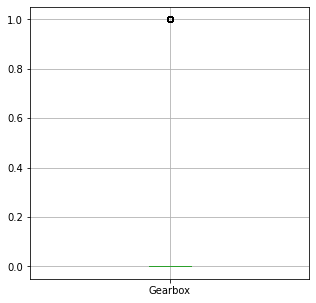

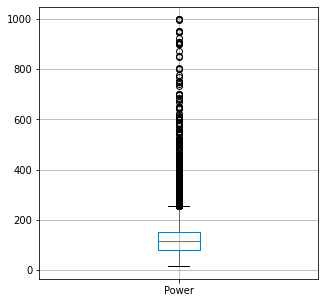

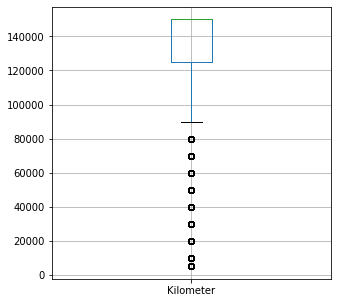

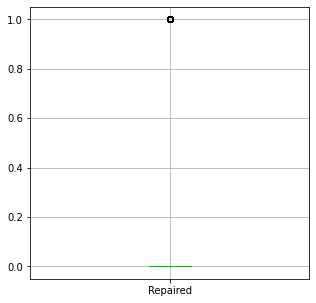

In [16]:
num_df = df.select_dtypes(include=numerics)
for col in num_df.columns:
    plt.subplots(figsize=(5, 5))
    num_df.boxplot(column=col)

### Работа с пропусками

Содержание пропусков по оставшимся колонкам:

In [17]:
df.isna().sum() / len(df)

Price               0.000000
VehicleType         0.040525
RegistrationYear    0.000000
Gearbox             0.019931
Power               0.000000
Model               0.040872
Kilometer           0.000000
FuelType            0.058161
Brand               0.000000
Repaired            0.153625
dtype: float64

Колонка **Repaired** содержит более 20% пропусков, она заполняется предсказаниями обученной модели catboost classifier.

Пропуски в колонках **VehicleType**, **Model**, **FuelType** заменяются на категорию 'other'.

Объекты с пропусками в колонке **Gearbox** удаляются.

In [18]:
df.loc[(df['Model'].isna())|(df['VehicleType'].isna())|(df['FuelType'].isna()), ['VehicleType', 'Model', 'FuelType']] = 'other'

In [19]:
df.drop(index=df.index[df['Gearbox'].isna()], inplace = True)

In [20]:
features = df.drop(columns=['Repaired'])
features.drop(index=df.index[df['Repaired'].isna()], inplace=True)
target = df[df['Repaired'].notna()]['Repaired']

In [21]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    random_state=12345,
    test_size=0.25,
    stratify=target)

cv_dataset = Pool(data=features_train,
                  label=target_train,
                  cat_features=['VehicleType', 'Model', 'FuelType', 'Brand'])

booster = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           verbose=10)

booster.fit(cv_dataset)
booster.set_feature_names(features_train.columns)

test_preds = booster.predict(features_test)
train_preds = booster.predict(features_train)

print(booster.score(features_train, target_train))
print(booster.score(features_test, target_test))

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 0.6330083	total: 603ms	remaining: 59.7s
10:	learn: 0.3770145	total: 4s	remaining: 32.4s
20:	learn: 0.3196498	total: 7.11s	remaining: 26.7s
30:	learn: 0.3039940	total: 10.2s	remaining: 22.8s
40:	learn: 0.2984650	total: 13.5s	remaining: 19.4s
50:	learn: 0.2951373	total: 17.1s	remaining: 16.4s
60:	learn: 0.2927947	total: 20.4s	remaining: 13s
70:	learn: 0.2912449	total: 23.9s	remaining: 9.75s
80:	learn: 0.2898348	total: 27.4s	remaining: 6.42s
90:	learn: 0.2886297	total: 31s	remaining: 3.06s
99:	learn: 0.2876234	total: 34.3s	remaining: 0us
0.889712010947316
0.8903547237409266


In [22]:
model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           verbose=10)
model.fit(cv_dataset)

0:	learn: 0.6330083	total: 422ms	remaining: 41.8s
10:	learn: 0.3770145	total: 3.84s	remaining: 31.1s
20:	learn: 0.3196498	total: 7.02s	remaining: 26.4s
30:	learn: 0.3039940	total: 9.83s	remaining: 21.9s
40:	learn: 0.2984650	total: 12.7s	remaining: 18.3s
50:	learn: 0.2951373	total: 15.5s	remaining: 14.9s
60:	learn: 0.2927947	total: 18.7s	remaining: 11.9s
70:	learn: 0.2912449	total: 21.6s	remaining: 8.84s
80:	learn: 0.2898348	total: 25s	remaining: 5.88s
90:	learn: 0.2886297	total: 28.3s	remaining: 2.79s
99:	learn: 0.2876234	total: 31.5s	remaining: 0us


In [23]:
df['Repaired'] = model.predict(df.loc[:, :'Brand'])

In [24]:
df.isna().sum() / len(df)

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
dtype: float64

<div id="total_drop"></div>

In [25]:
f'Всего объектов удалено: {source_df_len - len(df)}'

'Всего объектов удалено: 57863'

## Обучение моделей

In [26]:
res_table = {
    'Модель': ['Линейная регрессия', 'Случайный лес', 'LightGBM', 'CatBoost'],
    'Время обучения': [],
    'Время предсказания': [],
    'RMSE': []
}

In [27]:
f_t = split_dataset(df, 'Price', [], ['VehicleType', 'Model', 'FuelType', 'Brand'], ['Power', 'Kilometer'])

features_train, features_test = f_t[0]
target_train, target_test = f_t[1]

features_train.shape, features_test.shape

((201172, 9), (50294, 9))

### Наивная модель (среднее значение целевого признака)

In [28]:
model = DummyRegressor()
model.fit(features_train, target_train)
display(f'test RMSE = {mean_squared_error(target_test, model.predict(features_test), squared=False)}')

'test RMSE = 4668.064772355894'

### Линейная регрессия

In [29]:
model = LinearRegression()

In [30]:
start = time.time()
model.fit(features_train, target_train)
end = time.time()
res_table['Время обучения'].append(f'{(end-start) * 10**3}, ms')

In [31]:
start = time.time()
model.predict(features_test)
end = time.time()
res_table['Время предсказания'].append(f'{(end-start) * 10**3}, ms')

In [32]:
RMSE = mean_squared_error(target_test, model.predict(features_test), squared=False)
res_table['RMSE'].append(RMSE)
f'test RMSE = {RMSE}'

'test RMSE = 128190960.90720825'

### Случайный лес

In [33]:
model = RandomForestRegressor(random_state=12345)

grid_space={'max_depth':[3,5,10],
              'n_estimators':[30, 50],
           }
grid = GridSearchCV(model,param_grid=grid_space,cv=4,scoring='neg_root_mean_squared_error', verbose=2)
model_grid = grid.fit(features_train, target_train)
display(f'Best hyperparameters are: {model_grid.best_params_}')
display(f'Best estimator is: {model_grid.best_estimator_}')
display(f'Best score is: {model_grid.best_score_}')

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] END .......................max_depth=3, n_estimators=30; total time=   2.4s
[CV] END .......................max_depth=3, n_estimators=30; total time=   1.8s
[CV] END .......................max_depth=3, n_estimators=30; total time=   1.8s
[CV] END .......................max_depth=3, n_estimators=30; total time=   1.7s
[CV] END .......................max_depth=3, n_estimators=50; total time=   2.8s
[CV] END .......................max_depth=3, n_estimators=50; total time=   3.0s
[CV] END .......................max_depth=3, n_estimators=50; total time=   3.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   3.1s
[CV] END .......................max_depth=5, n_estimators=30; total time=   2.6s
[CV] END .......................max_depth=5, n_estimators=30; total time=   2.8s
[CV] END .......................max_depth=5, n_estimators=30; total time=   2.6s
[CV] END .......................max_depth=5, n_es

"Best hyperparameters are: {'max_depth': 10, 'n_estimators': 50}"

'Best estimator is: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345)'

'Best score is: -1823.1928887382492'

In [34]:
model = RandomForestRegressor(random_state=12345, max_depth=10, n_estimators=50)

In [35]:
start = time.time()
model.fit(features_train, target_train)
end = time.time()
res_table['Время обучения'].append(f'{(end-start) * 10**3}, ms')

In [36]:
start = time.time()
preds = model.predict(features_test)
end = time.time()
res_table['Время предсказания'].append(f'{(end-start) * 10**3}, ms')

In [37]:
RMSE = mean_squared_error(target_test, preds, squared=False)
res_table['RMSE'].append(RMSE)
f'test RMSE = {RMSE}'

'test RMSE = 10386.351832771052'

### LightGBM

In [38]:
del f_t
del features_train
del features_test
del target_train
del target_test

In [39]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(columns=['Price']), df['Price'], random_state=12345, test_size=0.2)
cat_cols = ['VehicleType', 'Model', 'FuelType', 'Brand']
for col in cat_cols:
    if col in list(features_train.columns):
        features_train[col] = features_train[col].astype('category')
    if col in list(features_test.columns):
        features_test[col] = features_test[col].astype('category')

train_data = lgb.Dataset(features_train, label = target_train, categorical_feature = cat_cols, free_raw_data=False)

In [40]:
params={}
params['seed'] = 12345
params['learning_rate'] = 0.1
params['min_data_in_leaf'] = 1
params['max_depth'] = 4
params['metric'] = 'rmse'
params['max_bin'] = 1000
params['verbose'] = -1

In [41]:
clf = lgb.cv(params, train_data, 100, nfold=4, callbacks=[lgb.early_stopping(stopping_rounds=5)])

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	cv_agg's rmse: 1729.33 + 8.36182


In [42]:
display(f"Номер лучшей итерации: {np.array(clf['rmse-mean']).argmin()}")
display(f"Лучший rmse: {np.array(clf['rmse-mean']).min()}")

'Номер лучшей итерации: 99'

'Лучший rmse: 1729.331351107085'

In [43]:
start = time.time()
clf=lgb.train(params,train_data, 100)
end = time.time()
res_table['Время обучения'].append(f'{(end-start) * 10**3}, ms')

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [44]:
start = time.time()
y_pred=clf.predict(features_test)
end = time.time()
res_table['Время предсказания'].append(f'{(end-start) * 10**3}, ms')

In [45]:
RMSE = mean_squared_error(target_test, y_pred, squared=False)
res_table['RMSE'].append(RMSE)
f'RMSE = {RMSE}'

'RMSE = 1724.9435212744315'

In [46]:
params['learning_rate'] = 0.05
params['max_depth'] = 5

In [47]:
clf = lgb.cv(params, train_data, 100, nfold=4, callbacks=[lgb.early_stopping(stopping_rounds=5)])

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	cv_agg's rmse: 1734.2 + 10.4438


In [48]:
display(f"Номер лучшей итерации: {np.array(clf['rmse-mean']).argmin()}")
display(f"Лучший rmse: {np.array(clf['rmse-mean']).min()}")

'Номер лучшей итерации: 99'

'Лучший rmse: 1734.1975049047116'

In [49]:
clf=lgb.train(params,train_data, 100)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [50]:
y_pred=clf.predict(features_test)

In [51]:
f'RMSE = {mean_squared_error(y_pred, target_test, squared=False)}'

'RMSE = 1731.2110361562954'

### Catboost

In [52]:
features_train, features_test, target_train, target_test = train_test_split(df.drop(columns=['Price']),
                                                                            df['Price'], random_state=12345, test_size=0.2)

cv_dataset = Pool(data=features_train,
                  label=target_train,
                  cat_features=['VehicleType', 'Model', 'FuelType', 'Brand'])
for iter, depth, lr in [[100, 4, 0.1],[100, 5,0.05]]:
    params = {"iterations": iter,
            "depth": depth,
            "loss_function": "RMSE",
            "learning_rate": lr,
            "verbose": iter // 10}

    scores = cv(cv_dataset,
              params,
              fold_count=4)

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


Training on fold [0/4]
0:	learn: 6297.8455638	test: 6326.6958455	best: 6326.6958455 (0)	total: 42.8ms	remaining: 4.24s
10:	learn: 3311.6922177	test: 3336.8926171	best: 3336.8926171 (10)	total: 361ms	remaining: 2.92s
20:	learn: 2468.9961582	test: 2495.3020605	best: 2495.3020605 (20)	total: 665ms	remaining: 2.5s
30:	learn: 2192.8675662	test: 2216.7623217	best: 2216.7623217 (30)	total: 992ms	remaining: 2.21s
40:	learn: 2065.3613178	test: 2088.6209249	best: 2088.6209249 (40)	total: 1.29s	remaining: 1.86s
50:	learn: 2002.0723640	test: 2025.2029929	best: 2025.2029929 (50)	total: 1.59s	remaining: 1.52s
60:	learn: 1964.4469663	test: 1987.8570970	best: 1987.8570970 (60)	total: 1.89s	remaining: 1.21s
70:	learn: 1936.0254872	test: 1960.7016371	best: 1960.7016371 (70)	total: 2.19s	remaining: 896ms
80:	learn: 1904.1752625	test: 1929.0863081	best: 1929.0863081 (80)	total: 2.49s	remaining: 584ms
90:	learn: 1884.3144454	test: 1909.9827367	best: 1909.9827367 (90)	total: 2.82s	remaining: 279ms
99:	learn

In [53]:
model = CatBoostRegressor(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='RMSE',
                           verbose=10)

In [54]:
start = time.time()
model.fit(cv_dataset)
end = time.time()
res_table['Время обучения'].append(f'{(end-start) * 10**3}, ms')

0:	learn: 4406.7188169	total: 49.9ms	remaining: 4.94s
10:	learn: 2903.0285859	total: 452ms	remaining: 3.65s
20:	learn: 2402.3405170	total: 827ms	remaining: 3.11s
30:	learn: 2168.1680468	total: 1.21s	remaining: 2.68s
40:	learn: 2068.7202366	total: 1.57s	remaining: 2.26s
50:	learn: 2010.7323078	total: 1.95s	remaining: 1.87s
60:	learn: 1964.4171366	total: 2.32s	remaining: 1.48s
70:	learn: 1935.8098326	total: 2.69s	remaining: 1.1s
80:	learn: 1914.1825717	total: 3.06s	remaining: 718ms
90:	learn: 1893.8364327	total: 3.43s	remaining: 339ms
99:	learn: 1879.7325280	total: 3.77s	remaining: 0us


In [55]:
start = time.time()
preds = model.predict(features_test)
end = time.time()
res_table['Время предсказания'].append(f'{(end-start) * 10**3}, ms')

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


In [56]:
RMSE = mean_squared_error(target_test, preds, squared=False)
res_table['RMSE'].append(RMSE)
f'RMSE = {RMSE}'

'RMSE = 1873.3627059308678'

Линейная регрессия и случайный лес не прошли проверку на адекватность. Были рассчитаны их RMSE, время обучения и время предсказания. Дольше всех обучался случайный лес, а худшая RMSE у линейной регрессии.

## Анализ моделей

In [57]:
pd.DataFrame(res_table)

,Модель,Время обучения,Время предсказания,RMSE
0,Линейная регрессия,"40.08769989013672, ms","9.237051010131836, ms",1.281910e+08
1,Случайный лес,"10008.27956199646, ms","66.21813774108887, ms",1.038635e+04
2,LightGBM,"8480.839252471924, ms","304.4171333312988, ms",1.724944e+03
3,CatBoost,"4807.2874546051025, ms","39.24417495727539, ms",1.873363e+03


Модель LightGBM лучшая по точности предсказаний. Т.к. CatBoost оказался лучшим по скорости предсказания, среди моделей, чей RMSE меньше 2500, то выбрать стоит его.

## Итоги

- Из исходных данных было удалено 57863 пропусков и 45040 дубликатов.
- Из исходных данных были удалены объекты с аномальными значениями: околонулевая цена, мощность и неактуальный год регистрации
- Из данных были отброшены неинформативные колонки: **DateCrawled**, **DateCreated**, **PostalCode**, **LastSeen**, **RegistrationMonth**
- Подготовлены тренировочная и тестовая выборки для обучения линейной регрессии, случайного леса и моделей градиентного бустинга
- Все модели успешно обучены
- RMSE для каждой модели для каждой модели на тестовой выборке составил:
    - Линейная регрессия - 2834
    - Случайный лес - 1828
    - LightGBM - 1725
    - CatBoostRegressor - 1873
- Модели были проанализированны по скорости обучения, предсказания и метрики RMSE. Выбрана модель CatBoostRegressor, т.к. она обладает лучшей скоростью предсказания.